In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from time import time

In [2]:
sess = tf.Session()

In [3]:
def make_block_linear_operator(block_sizes, variable=tf.Variable):
    dim = sum(block_sizes)
    psd_args = dict(
        is_non_singular=True,
        is_self_adjoint=True,
        is_positive_definite=True,
    )
    diagonal = tf.zeros([dim])
    variables = []

    offset = 0
    tic = time()
    for block_size in block_sizes:
        pad_before = offset
        pad_after = dim - (offset + block_size)
        v = variable(0.)
        variables.append(v)
        diagonal += tf.pad(tf.exp(v) * tf.ones([block_size]),
                           [[pad_before, pad_after]])
        offset += block_size
    linop = tf.linalg.LinearOperatorDiag(diagonal, **psd_args)
    print(f"diagonal operator built in {time() - tic:.3f}s")

    offset = 0
    for block_size in block_sizes:
        tic = time()
        pad_before = offset
        pad_after = dim - (offset + block_size)
        v = variable(.3)
        variables.append(v)
        u = tf.pad(v * tf.ones([block_size, 1]),
                   [[pad_before, pad_after], [0, 0]])
        linop = tf.linalg.LinearOperatorLowRankUpdate(linop, u=u, v=u, **psd_args)
        offset += block_size
        print(f"lowrank update operator built in {time() - tic:.3f}s")
    return linop, variables 

In [4]:
K, variables = make_block_linear_operator([3, 5, 5, 1], variable=tf.Variable)

sess.run(tf.global_variables_initializer())
%time sess.run(K.log_abs_determinant())

diagonal operator built in 0.040s
lowrank update operator built in 0.020s
lowrank update operator built in 0.029s
lowrank update operator built in 0.052s
lowrank update operator built in 0.219s
CPU times: user 72 ms, sys: 0 ns, total: 72 ms
Wall time: 73.1 ms


1.0683217

In [5]:
%time sess.run(tf.gradients(K.log_abs_determinant(), variables))

CPU times: user 1.13 s, sys: 4 ms, total: 1.13 s
Wall time: 1.12 s


[2.7874014,
 4.6896553,
 4.6896553,
 0.9174312,
 1.4173228,
 2.0689652,
 2.0689652,
 0.5504587]

In [6]:
# val_and_grad_fn = tfe.value_and_gradients_function(lambda K: K.log_abs_determinant())
# val_and_grad_fn(K)

In [7]:
K_tensor = K.matmul(tf.eye(K.shape[0].value))

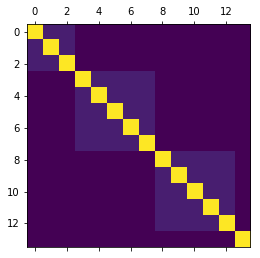

In [8]:
plt.matshow(sess.run(K_tensor));

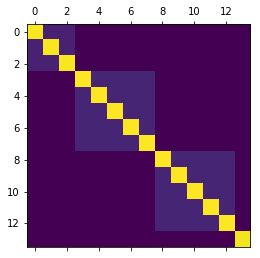

In [9]:
plt.matshow(sess.run(tf.linalg.expm(K_tensor)));

In [ ]:
%time big_K, big_variables = make_block_linear_operator([4096] * 10)

diagonal operator built in 0.115s
lowrank update operator built in 0.021s
lowrank update operator built in 0.032s
lowrank update operator built in 0.056s
lowrank update operator built in 0.096s
lowrank update operator built in 0.352s
lowrank update operator built in 0.374s
lowrank update operator built in 0.745s
lowrank update operator built in 1.753s


In [ ]:
# %load_ext line_profiler

In [ ]:
# %lprun -f make_block_linear_operator make_block_linear_operator([4096] * 10)

In [ ]:
big_K.shape

In [ ]:
np.product(big_K.shape).value / 1e9

In [ ]:
len(big_variables)

In [ ]:
%time big_det = big_K.log_abs_determinant()

In [ ]:
sess.run(tf.global_variables_initializer())
%time sess.run(big_det)

In [ ]:
# tf.linalg.expm(big_K)

## Part two: backups

In [ ]:
# try:
#     tfe.enable_eager_execution()
# except ValueError:
#     # Hide the annoying lack of idem-potency.
#     pass

In [ ]:
block_boundaries = [0, 5, 8, 10]
# block_boundaries = [0]
# block_boundaries.append(block_boundaries[-1] + 784 * 10)
# block_boundaries.append(block_boundaries[-1] + 10)
# block_boundaries.append(block_boundaries[-1] + 10 * 10)
# block_boundaries.append(block_boundaries[-1] + 10)
# block_boundaries.append(block_boundaries[-1] + 10 * 10)
# block_boundaries.append(block_boundaries[-1] + 10)



def outer(v):
    return tf.matmul(tf.reshape(v, (-1, 1)),
                     tf.reshape(v, (1, -1)))


def parametrized_precision(block_boundaries):
    variables = []
    n_params = block_boundaries[-1]
    K = tf.zeros(shape=(n_params, n_params))
    for i, j in zip(block_boundaries, block_boundaries[1:]):
        # Diagonal for the current block
        diag_mask_i = np.zeros(n_params, dtype=np.float32)
        diag_mask_i[i:j] = 1
        diag_mask_i = tf.constant(diag_mask_i)
        K_i_var = tf.Variable(0.5, dtype=np.float32)
        K_i = tf.diag(tf.exp(K_i_var) * diag_mask_i)
        variables.append(K_i_var)
        K += K_i
        
        # Rank-one for the current parameter block
        ro_mask_i = np.zeros(n_params, dtype=np.float32)
        ro_mask_i[i:j] = 1
        ro_mask_i = tf.constant(ro_mask_i)
        ro_var_i = tf.Variable(1, dtype=np.float32)
        ro_i = outer(ro_var_i * ro_mask_i)
        variables.append(ro_var_i)
        K += ro_i
    for i, j in zip(block_boundaries, block_boundaries[2:]):
        # Rank-one for consecutive blocks interactions
        ro_mask_i = np.zeros(n_params, dtype=np.float32)
        ro_mask_i[i:j] = 1
        ro_mask_i = tf.constant(ro_mask_i)
        ro_var_i = tf.Variable(1., dtype=np.float32)
        ro_i = outer(ro_var_i * ro_mask_i)
        variables.append(ro_var_i)
        K += ro_i
    return K, variables

K, variables = parametrized_precision(block_boundaries)

In [ ]:
sess.run(tf.global_variables_initializer())
K = sess.run(K)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(K)
len(variables)

In [ ]:
tf.linalg.det(K)

In [ ]:
eigvals = sess.run(tf.linalg.eigh(K)[0])
plt.bar(np.arange(K.shape[0]), eigvals)
eigvals

In [ ]:
C = sess.run(tf.linalg.inv(K))
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.matshow(C)

In [ ]:
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance


model = MultivariateNormalFullCovariance(loc=tf.zeros([C.shape[0]], dtype=np.float32), covariance_matrix=C)

In [ ]:
data = sess.run(model.sample(100))
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(sess.run(tf.linalg.inv(tf.matmul(tf.transpose(data), data))));

In [ ]:
# from sklearn.covariance import graph_lasso

# gl = graph_lasso(np.asarray(tf.matmul(tf.transpose(data), data)), 1)
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.matshow(gl[1])

In [ ]:
data_large = sess.run(model.sample(10000))
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(sess.run(tf.linalg.inv(tf.matmul(tf.transpose(data_large), data_large))));